In [1]:
# %pip install graphviz
from graphviz import Digraph
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value():
    def __init__(self, data=0.0, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data + other.data, (self, other), "+")
        def _add_backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _add_backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _mul_backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _mul_backward
        return out
    
    def __rmul__(self, other):
        return self * other # == return self * other 他会自动解构成前面的形式

    def __truediv__(self, other):
        # c = a / b ==> a * b**(-1) c._prev = {Value(a), Value(b**-1)} c._backward = _mul_backward
        return self * other**(-1)
    
    def __rtruediv__(self, other):
        return other * self**(-1)

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        # f(self) = self ** other
        assert isinstance(other, (float, int)), "only support float type or int type"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _pow_backward():
            self.grad += out.grad * other * (self.data**(other - 1))
        out._backward = _pow_backward
        return out 
    
    def tanh(self):
        x = (np.exp(self.data*2) - 1) / (np.exp(self.data*2) + 1)
        out = Value(x, (self,), "tanh")
        def _tanh_backward():
            self.grad += out.grad * (1 - x**2)
        out._backward = _tanh_backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        def _exp_backward():
            self.grad += out.grad * out.data
        out._backward = _exp_backward
        return out

    def backward(self):
        visited = set()
        topo = []
        def build_topo(u):
            visited.add(u)
            for v in u._prev:
                if v not in visited:
                    build_topo(v)
            topo.append(u)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()   

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{label %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot # ${workspaceFolder}/.env

In [4]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# w1.data += 0.000001
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
b = Value(6.8813735870195432, label='b')
y = x1w1 + x2w2 + b; y.label = 'y' 
print(y._prev)
tmp1, tmp2 = y._prev
print(tmp1._prev, tmp2._prev)
# 这里 我是对b的求和操作一起算了，但是加完之后会新创建一个Value，然后继续下一步
# 所以可视化出来永远是两个子节点，和一个op操作，不可能出现三个节点一起得到y的。是一个满二叉树

L = y.tanh()
L

{Value(data=-6.0), Value(data=6.881373587019543)}
{Value(data=0.0), Value(data=-6.0)} set()


Value(data=0.7071067811865476)

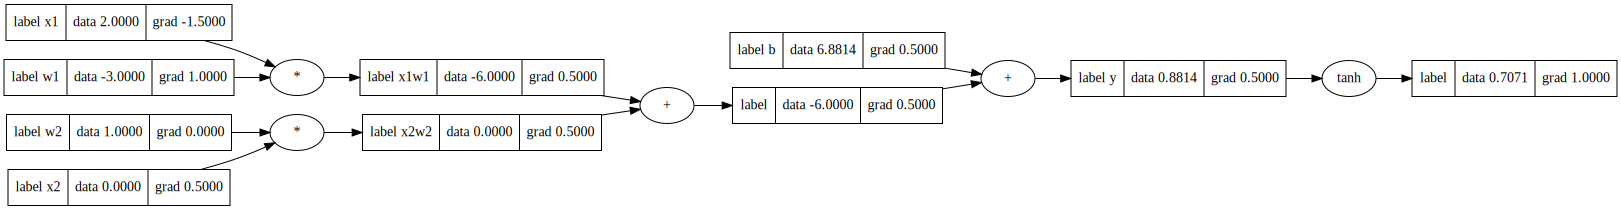

In [5]:
L.backward()
draw_dot(L)

### 目标
验证 $tanh(x)$ 函数封装成一个整体进行求导 $\frac{d tanh(x)}{dx} = 1 - tanh(x)^2$, 与分开到 atomic element 的结果是一样的 
$$
tanh(x) = \frac{e^{2x} - 1}{ e^{2x} + 1}
$$
- 实现$e^x$
- 实现 `a + 1`, `1 + a`, `a * 2`, `2 * a`
    
    以加法为例：

    - 通过把`1`转成`Value`类，可以实现：a.\_\_mul\_\_(1), 
    
    
    - 调用 1.\_\_mul\_\_(a) 不成功会继续调用 a.\_\_rmul\_\_(1)，我们可以实现这个功能，重定向到a.\_\_mul\_\_(1)
- 实现 负数
- 实现 除法
    - `a / b` ==> `a * b**(-1)` ==> 实现 负数 and power operation 幂运算

In [6]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# w1.data += 0.000001
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
b = Value(6.8813735870195432, label='b')
y = x1w1 + x2w2 + b; y.label = 'y' 
# 
k = y*2; k.label = 'k'
o = k.exp(); o.label = 'o'
L = (o - 1) / (o + 1)
L

Value(data=0.7071067811865477)

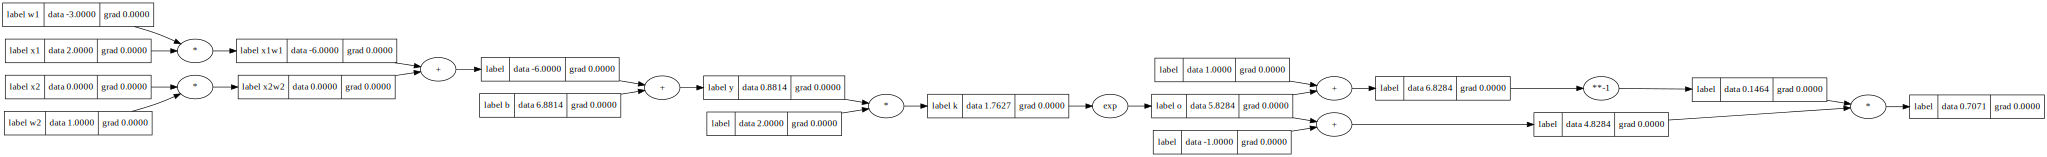

In [7]:
draw_dot(L)

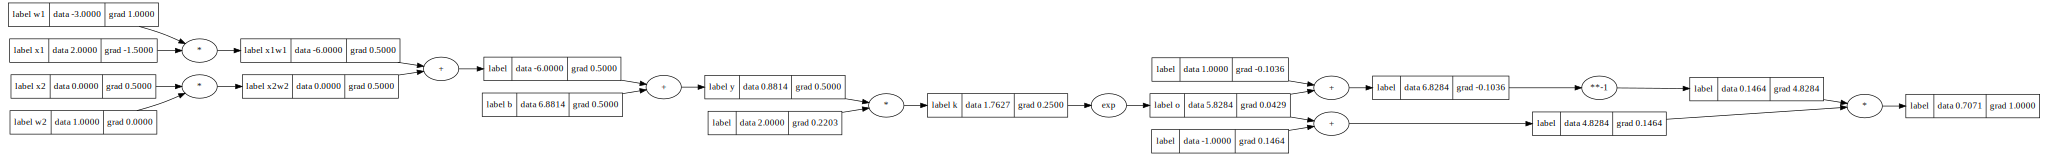

In [8]:
L.backward()
draw_dot(L)

In [83]:
import random

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    def parameters(self):
        return []
    
class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))        
    
    def __call__(self, x):
        out = sum([wi * xi for wi, xi in zip(self.w, x)], start=0.0)
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # return [o for n in self.neurons for o in n.__call__()]
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out # 这样方便最后求loss的时候写zip

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP(Module):
    def __init__(self, nin, nout):
        self.dim = [nin] + nout # 3, 4, 5 [3, 4], [4, 5]
        self.layers = [Layer(self.dim[i], self.dim[i+1]) for i in range(len(nout))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]        

random.seed(42)
x = [[random.random() for _ in range(3)] for _ in range(2)]
y = [1.0, 0.0]
print(list(zip(x, y)))
network = MLP(3, [4, 4, 1])
# 不要用range
# y_pred = [network(x[i]) for i in range(2)]
# loss = sum([(y_pred[i] - y[i])**2 for i in range(2)],0)
# loss = sum([(y_pred[i].data - y[i])**2 for i in range(2)],0) -> 加了.data loss.backward会显示float has no backward

[([0.6394267984578837, 0.025010755222666936, 0.27502931836911926], 1.0), ([0.22321073814882275, 0.7364712141640124, 0.6766994874229113], 0.0)]


下面这里自己感受data和grad的关系，以及如何通过改变data从而影响最终的loss的

In [63]:
y_pred = [network(xx) for xx in x]
print(y_pred)
loss = sum((yout - ygt)**2 for ygt, yout in zip(y, y_pred))

print(loss)
network.zero_grad()
loss.backward()

[Value(data=0.7118791761769276), Value(data=0.8796928589570443)]
Value(data=0.8568731352205041)


In [64]:
network.layers[0].neurons[0].w[0].grad

0.007906440526463582

In [65]:
network.layers[0].neurons[0].w[0].data

1.334359135409691

In [66]:
network.layers[0].neurons[0].w[0].data += 0.1
network.layers[0].neurons[0].w[0].data

1.4343591354096912

In [ ]:
def train_one_epoch(epoch):
    y_pred = [network(xx) for xx in x]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(y_pred, y)] , 0)

    network.zero_grad()
    loss.backward()

    for p in network.parameters():
        p.data += -0.1 * (1 - epoch / 100) * p.grad
    print(f"epoch:{epoch} ==> loss:{loss.data:.3e} | lr: {0.1 * (1 - epoch / 100):.3f} | y_pred: {y_pred}")
    
for _ in range(30):  
    train_one_epoch(_)

epoch:0 ==> loss:8.673e-01 | lr: -0.100 | y_pred: [Value(data=0.5972136297043489), Value(data=0.8396654761039809)]
epoch:1 ==> loss:2.443e-01 | lr: -0.099 | y_pred: [Value(data=0.5689389180039071), Value(data=0.24185828686149183)]
epoch:2 ==> loss:1.047e-01 | lr: -0.098 | y_pred: [Value(data=0.7204920637928498), Value(data=0.16311615255966352)]
epoch:3 ==> loss:3.843e-02 | lr: -0.097 | y_pred: [Value(data=0.8339679871928298), Value(data=0.10425001383791441)]
epoch:4 ==> loss:1.227e-02 | lr: -0.096 | y_pred: [Value(data=0.9079159989042522), Value(data=0.06157937138881295)]
epoch:5 ==> loss:3.550e-03 | lr: -0.095 | y_pred: [Value(data=0.9510911551520793), Value(data=0.03402833314110365)]
epoch:6 ==> loss:9.715e-04 | lr: -0.094 | y_pred: [Value(data=0.9745902438747862), Value(data=0.018051394469368903)]
epoch:7 ==> loss:2.599e-04 | lr: -0.093 | y_pred: [Value(data=0.9869032382916874), Value(data=0.009399073261692037)]
epoch:8 ==> loss:6.933e-05 | lr: -0.092 | y_pred: [Value(data=0.9932464

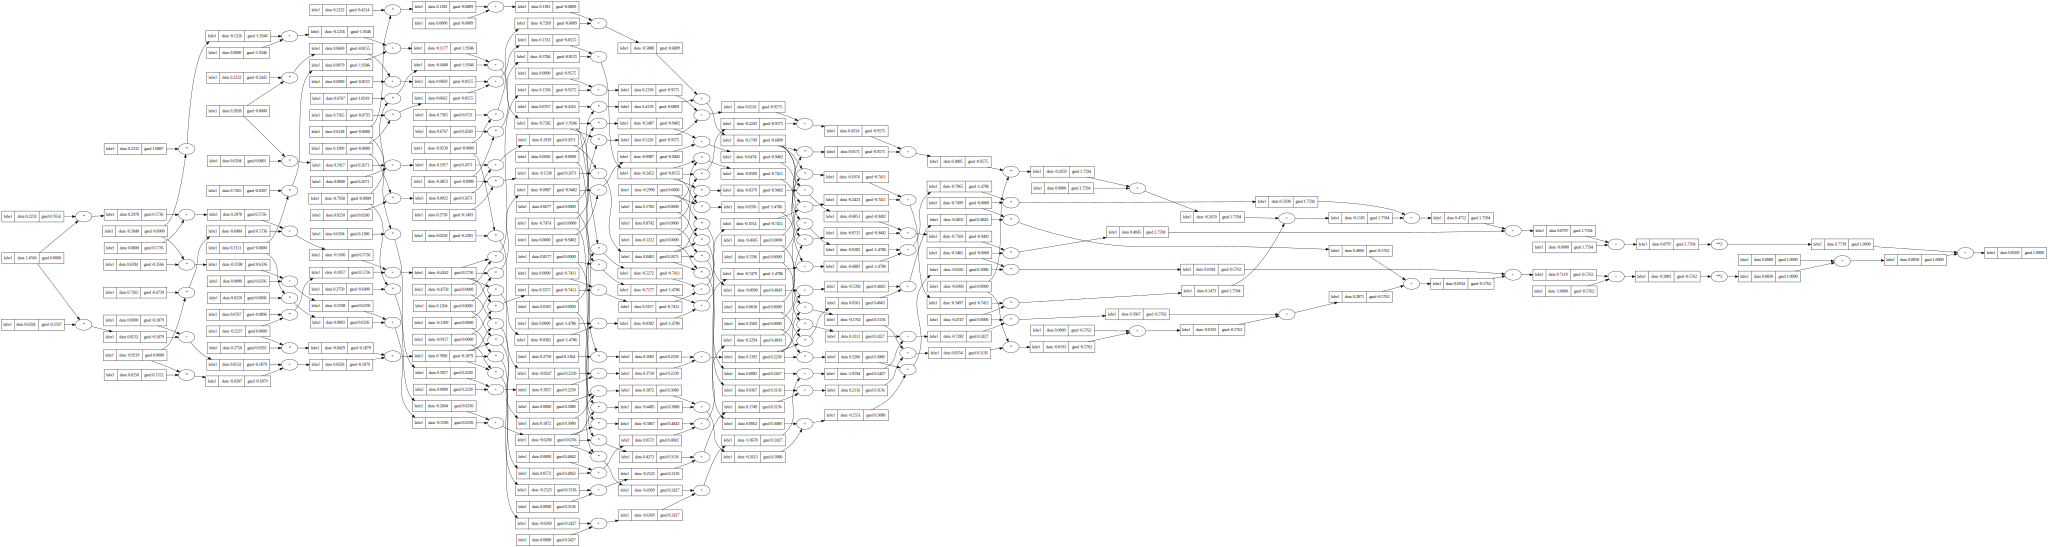

In [85]:
draw_dot(loss)